TIME SERIES ANALYSIS FOR STOCK MARKET DATA SPECIFICALLY AMAZON. DATA SOURCE IS YAHOO.API.


**1.   Data Exploration**

**2.   Making a time series window**

**3.   Feature engineering from the data**

**4. Make an ARIMA model**


**5.Make a LSTM model with multiple features**






In [77]:
import pandas as pd
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('AMZN.csv')
# Dataset is now stored in a Pandas Dataframe


In [78]:
pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**install mxnet a python package for time series data great for visualization**

In [79]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

Setting up mxnet model 
Need this to create an ARIMA model and Fourier series model easily 

In [82]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

**Always sort time and format it properily for time series data. Here sorted out it month-date-year format.** 

In [83]:
d=pd.read_csv("dat_amazon.csv")

In [84]:
d.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-08-30,12.3495,12.5000,12.2625,12.3110,12.3110,72950000
1,2012-08-31,12.4035,12.4725,12.2750,12.4135,12.4135,66950000
2,2012-09-04,12.4135,12.5500,12.2330,12.3940,12.3940,79016000
3,2012-09-05,12.3805,12.4305,12.2650,12.3110,12.3110,53052000
4,2012-09-06,12.4115,12.6350,12.3600,12.5690,12.5690,107228000


In [85]:
import pandas as pd

In [86]:
dataset_ex_df = pd.read_csv("dat_amazon.csv", header=0, parse_dates=[0], date_parser=parser)

In [87]:
dataset_ex_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-08-30,12.3495,12.5000,12.2625,12.3110,12.3110,72950000
1,2012-08-31,12.4035,12.4725,12.2750,12.4135,12.4135,66950000
2,2012-09-04,12.4135,12.5500,12.2330,12.3940,12.3940,79016000
3,2012-09-05,12.3805,12.4305,12.2650,12.3110,12.3110,53052000
4,2012-09-06,12.4115,12.6350,12.3600,12.5690,12.5690,107228000


In [88]:
dataset_ex_df[['Date', 'Close']].head(3)

,Date,Close
0,2012-08-30,12.3110
1,2012-08-31,12.4135
2,2012-09-04,12.3940


In [89]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2263 number of days in the dataset.


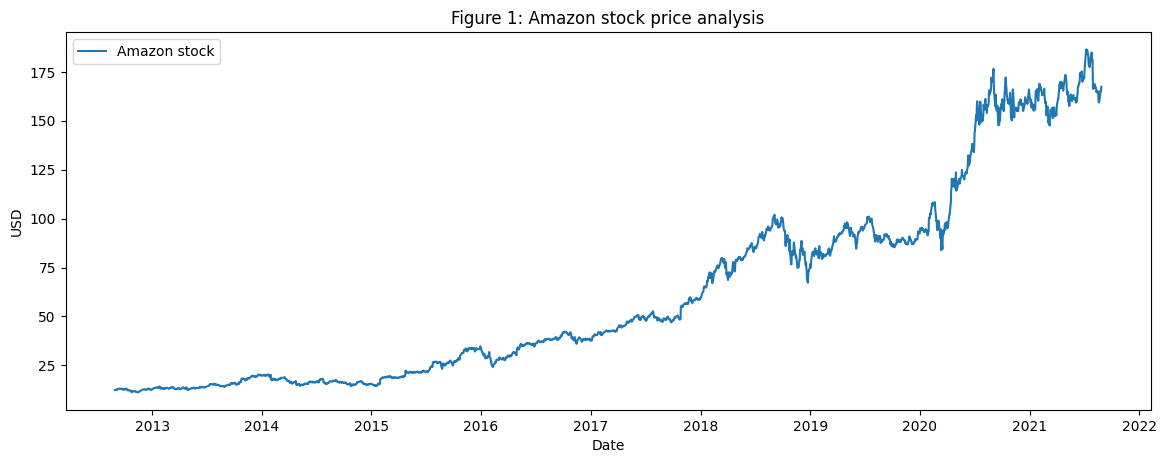

In [90]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Amazon stock')
# plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
# plt.vlines(datetime.date(2020,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1: Amazon stock price analysis')
plt.legend()
plt.show()


In [91]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

In [92]:
#@title
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [93]:
#@title
dataset_TI_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2012-08-30,12.3495,12.5000,12.2625,12.3110,12.3110,72950000,NaN,NaN,12.311000,12.311000,0.000000,NaN,NaN,NaN,12.311000,-0.876890
1,2012-08-31,12.4035,12.4725,12.2750,12.4135,12.4135,66950000,NaN,NaN,12.364221,12.366521,0.002300,NaN,NaN,NaN,12.387875,-0.875865
2,2012-09-04,12.4135,12.5500,12.2330,12.3940,12.3940,79016000,NaN,NaN,12.374920,12.377246,0.002326,NaN,NaN,NaN,12.392115,-0.876060
3,2012-09-05,12.3805,12.4305,12.2650,12.3110,12.3110,53052000,NaN,NaN,12.357051,12.356335,-0.000716,NaN,NaN,NaN,12.337362,-0.876890
4,2012-09-06,12.4115,12.6350,12.3600,12.5690,12.5690,107228000,NaN,NaN,12.406203,12.414115,0.007912,NaN,NaN,NaN,12.492426,-0.874310


In [94]:
#@title
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

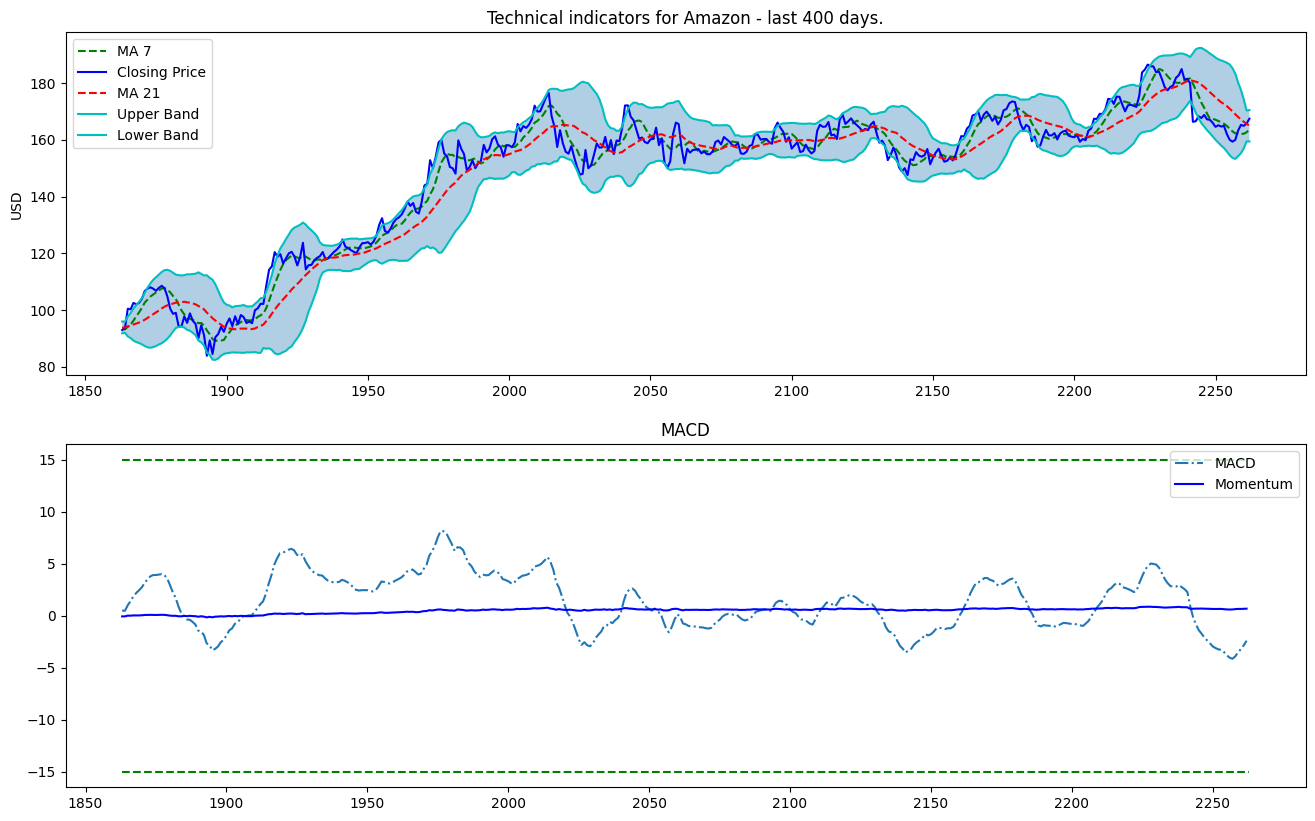

In [95]:
#@title
plot_technical_indicators(dataset_TI_df, 400)

# **ARIMA**

In [96]:
data_FT = dataset_ex_df[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [97]:
dataset_ex_df.describe()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
count,2263.000000,2263.000000,2263.000000,2263.000000,2263.000000,2.263000e+03,2257.000000,2243.000000,2263.000000,2263.000000,2263.000000,2244.000000,2244.000000,2244.000000,2263.000000,2263.000000
mean,61.999181,62.630978,61.281124,61.977003,61.977003,8.091675e+07,61.905247,61.740716,61.121550,61.606335,0.484785,1.855255,65.463486,58.042465,61.942875,-0.380230
std,49.296628,49.827968,48.681711,49.255584,49.255584,4.320686e+07,49.117840,48.818132,48.634376,48.991909,1.431521,1.881983,51.882316,45.906004,49.227959,0.492556
min,11.065500,11.258000,10.909000,11.030000,11.030000,1.762600e+07,11.253643,11.514690,11.662005,11.397036,-4.141533,0.135784,11.993651,10.722335,11.089738,-0.889700
25%,18.552749,18.725000,18.369999,18.599501,18.599501,5.357600e+07,18.603786,18.653048,18.308098,18.421348,-0.121173,0.501234,19.526858,17.338142,18.576222,-0.814005
50%,42.400002,42.599499,42.176498,42.368999,42.368999,6.936000e+07,42.478214,42.491476,41.740756,42.269976,0.255674,1.097090,43.256250,41.212090,42.390462,-0.576310
75%,90.870498,91.500000,90.007499,90.811001,90.811001,9.413000e+07,90.467072,90.765024,90.893212,90.668323,0.938610,2.563349,95.494741,85.958762,90.805946,-0.091890
max,187.199997,188.654007,184.839493,186.570496,186.570496,4.771220e+08,185.004713,181.068333,178.839505,181.298717,8.134473,10.262727,192.466075,173.844502,185.891305,0.865705


In [98]:
def forecast_accuracy(forecast, actual):
    # mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mape=0.1938
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

In [99]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Implementation of AUTO-ARIMA 

In [100]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('dat_amazon.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=85108.140, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=89405.197, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=85269.862, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=88009.165, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=84848.367, Time=1.37 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=85203.771, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=84845.219, Time=1.32 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=85060.415, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=84832.160, Time=1.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=84835.247, Time=1.29 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=84836.721, Time=3.56 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=84869.657, Time=2.01 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=84849.283, Time=3.66 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 16.159 seconds
        

Best Arima Model came at p=3,d=0,q=2

In [101]:
# from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:1501]
test = df.value[1501:]

In [102]:
import statsmodels.api as sm

In [103]:
# Build Model


model = sm.tsa.arima.ARIMA(train, order=(3,0,2))
result = model.fit()
print(result.summary())



                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1501
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -28208.483
Date:                Wed, 17 Aug 2022   AIC                          56430.966
Time:                        10:49:25   BIC                          56468.163
Sample:                             0   HQIC                         56444.823
                               - 1501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.651e+07   5.11e-09    1.5e+16      0.000    7.65e+07    7.65e+07
ar.L1          1.0048      0.225      4.466      0.000       0.564       1.446
ar.L2         -0.0184      0.332     -0.056      0.9

In [104]:
# Forecast
fc= result.forecast(762, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)



In [105]:
forecast_accuracy(fc,test.values)

{'mape': 0.1938,
 'me': -12921509.682515807,
 'mae': 29810056.398997784,
 'mpe': 0.013427055349659501,
 'rmse': 43265050.78381709,
 'corr': 0.010303493053402321,
 'minmax': 0.26256600870127966}

In [106]:
#@title
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

In [107]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)

In [108]:
dataset_TI_df

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2012-08-30,12.349500,12.500000,12.262500,12.311000,12.311000,72950000,NaN,NaN,12.311000,12.311000,0.000000,NaN,NaN,NaN,12.311000,-0.876890
1,2012-08-31,12.403500,12.472500,12.275000,12.413500,12.413500,66950000,NaN,NaN,12.364221,12.366521,0.002300,NaN,NaN,NaN,12.387875,-0.875865
2,2012-09-04,12.413500,12.550000,12.233000,12.394000,12.394000,79016000,NaN,NaN,12.374920,12.377246,0.002326,NaN,NaN,NaN,12.392115,-0.876060
3,2012-09-05,12.380500,12.430500,12.265000,12.311000,12.311000,53052000,NaN,NaN,12.357051,12.356335,-0.000716,NaN,NaN,NaN,12.337362,-0.876890
4,2012-09-06,12.411500,12.635000,12.360000,12.569000,12.569000,107228000,NaN,NaN,12.406203,12.414115,0.007912,NaN,NaN,NaN,12.492426,-0.874310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,2021-08-23,160.595001,164.044998,160.500504,163.293503,163.293503,65362000,162.069358,168.107810,167.959094,164.052762,-3.906332,6.496182,180.256015,154.271286,162.188765,0.632935
2259,2021-08-24,164.000000,165.774506,163.729004,165.289001,165.289001,51036000,162.153715,167.169620,167.761310,164.242952,-3.518357,5.597418,177.656962,155.267289,164.255589,0.652890
2260,2021-08-25,165.493500,166.050003,164.307495,164.959000,164.959000,33606000,162.155073,166.390548,167.553731,164.353114,-3.200617,4.336043,174.306360,156.962190,164.724530,0.649590
2261,2021-08-26,164.949997,166.600006,164.800003,165.800003,165.800003,41976000,162.683930,165.642167,167.423825,164.575712,-2.848113,2.723349,170.371174,159.477776,165.441512,0.658000


In [109]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

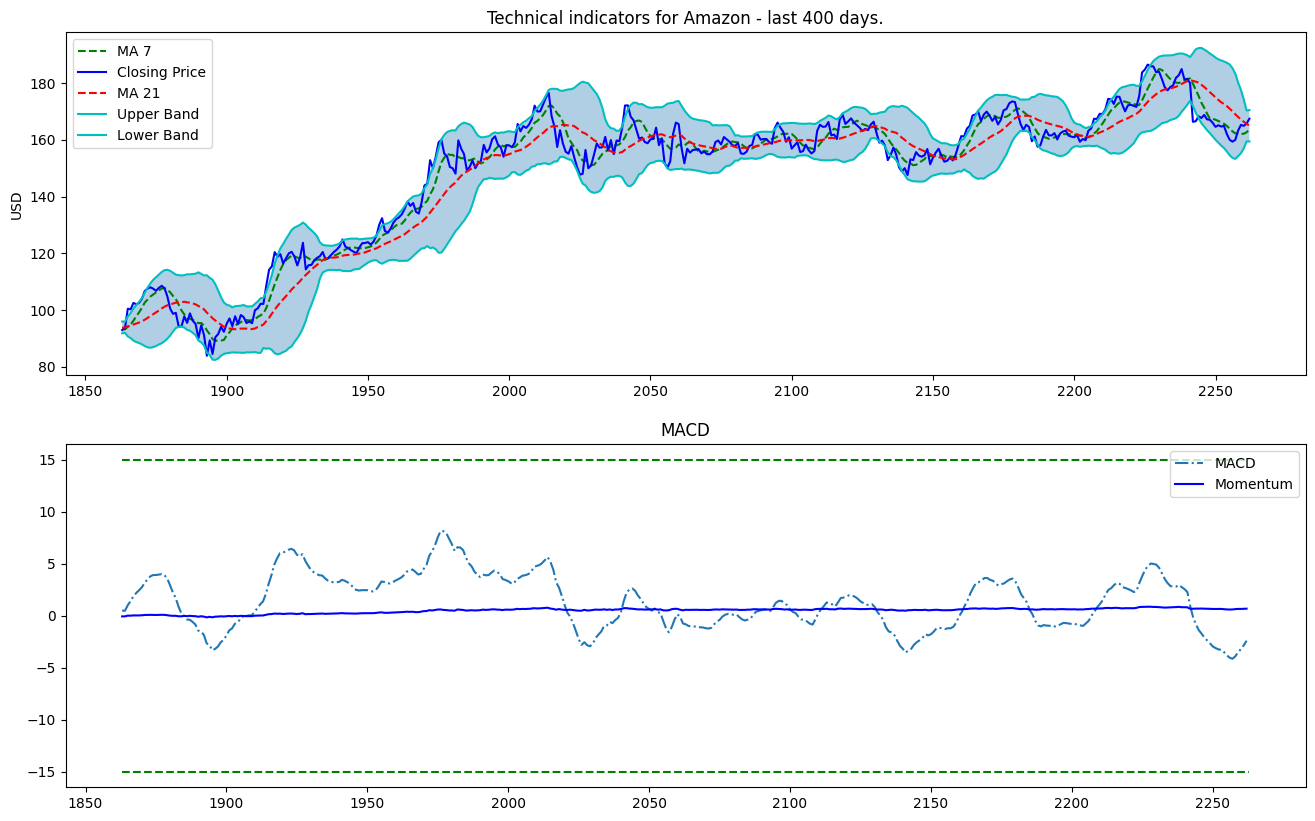

In [110]:
plot_technical_indicators(dataset_TI_df, 400)

Prophet Model

In [111]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
from prophet import Prophet

In [113]:
d=dataset_ex_df.copy()

In [114]:
data=d[['Date', 'Close']]

In [115]:
# Drop the columns
data.rename(columns={'Date': 'ds','Close': 'y'},inplace=True)
data.head()

,ds,y
0,2012-08-30,12.3110
1,2012-08-31,12.4135
2,2012-09-04,12.3940
3,2012-09-05,12.3110
4,2012-09-06,12.5690


In [116]:
train = data.iloc[:1501]
test = data.iloc[1501:]

In [117]:
m = Prophet()
m.fit(train)
# Create Future dates
future_prices = m.make_future_dataframe(periods=762)

# Predict Prices
forecast = m.predict(future_prices)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm32uxese/gafifs79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm32uxese/76av2wo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71101', 'data', 'file=/tmp/tmpm32uxese/gafifs79.json', 'init=/tmp/tmpm32uxese/76av2wo8.json', 'output', 'file=/tmp/tmpnibpyi_p/prophet_model-20220817104930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [118]:
fc=forecast[1501:]

In [119]:
fc=fc[['ds','trend']]

In [120]:
fc

,ds,trend
1501,2018-08-18,88.542170
1502,2018-08-19,88.647826
1503,2018-08-20,88.753483
1504,2018-08-21,88.859140
1505,2018-08-22,88.964796
...,...,...
2258,2020-09-13,168.524167
2259,2020-09-14,168.629824
2260,2020-09-15,168.735480
2261,2020-09-16,168.841137


In [121]:
a=fc['trend']

In [122]:
a.reset_index(drop=True , inplace=True)


In [123]:
a

0       88.542170
1       88.647826
2       88.753483
3       88.859140
4       88.964796
          ...    
757    168.524167
758    168.629824
759    168.735480
760    168.841137
761    168.946793
Name: trend, Length: 762, dtype: float64

LSTM

In [124]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_TI_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,12.3495,12.5000,12.2625,12.3110,12.3110,72950000,NaN,NaN,12.311000,12.311000,0.000000,NaN,NaN,NaN,12.311000,-0.876890
1,12.4035,12.4725,12.2750,12.4135,12.4135,66950000,NaN,NaN,12.364221,12.366521,0.002300,NaN,NaN,NaN,12.387875,-0.875865
2,12.4135,12.5500,12.2330,12.3940,12.3940,79016000,NaN,NaN,12.374920,12.377246,0.002326,NaN,NaN,NaN,12.392115,-0.876060
3,12.3805,12.4305,12.2650,12.3110,12.3110,53052000,NaN,NaN,12.357051,12.356335,-0.000716,NaN,NaN,NaN,12.337362,-0.876890
4,12.4115,12.6350,12.3600,12.5690,12.5690,107228000,NaN,NaN,12.406203,12.414115,0.007912,NaN,NaN,NaN,12.492426,-0.874310
5,12.6925,12.9710,12.6760,12.9570,12.9570,100590000,NaN,NaN,12.516523,12.546065,0.029542,NaN,NaN,NaN,12.802567,-0.870430
6,12.9500,13.0000,12.8410,12.8545,12.8545,51344000,12.544286,NaN,12.576631,12.614891,0.038260,NaN,NaN,NaN,12.837205,-0.871455


In [125]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 2263 samples, and 16 features.


In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [127]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

In [128]:
open_training = train.iloc[:, 1:2].values

Normalise the data

In [129]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])

**USING 5FEATURES :**


**USING THE BEST 5 FEATURES FROM THE RESULT OF THE XGBOOST. ITS QUITE OBVIOUS THAT A SINGLE FEATURE WILL NOT WORK SO WE USE THE 6 FEATURES THAT
COULD GENERATE THE BEST OUTCOME FROM XGBOOST**

In [130]:
dataset = dataset_ex_df[['Open', 'Close','High','Adj Close','Low']]

In [131]:
dataset.head()

,Open,Close,High,Adj Close,Low
0,12.3495,12.3110,12.5000,12.3110,12.2625
1,12.4035,12.4135,12.4725,12.4135,12.2750
2,12.4135,12.3940,12.5500,12.3940,12.2330
3,12.3805,12.3110,12.4305,12.3110,12.2650
4,12.4115,12.5690,12.6350,12.5690,12.3600


In [132]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [133]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


In [134]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [135]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])

In [136]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [137]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

In [138]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [139]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [140]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [141]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1


In [142]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [143]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1695/1695 - 9s - loss: 0.1397 - mae: 0.2805 - 9s/epoch - 5ms/step
Epoch 2/50
1695/1695 - 6s - loss: 0.0948 - mae: 0.2281 - 6s/epoch - 4ms/step
Epoch 3/50
1695/1695 - 7s - loss: 0.0755 - mae: 0.2126 - 7s/epoch - 4ms/step
Epoch 4/50
1695/1695 - 7s - loss: 0.0654 - mae: 0.2051 - 7s/epoch - 4ms/step
Epoch 5/50
1695/1695 - 7s - loss: 0.0597 - mae: 0.1991 - 7s/epoch - 4ms/step
Epoch 6/50
1695/1695 - 7s - loss: 0.0562 - mae: 0.1947 - 7s/epoch - 4ms/step
Epoch 7/50
1695/1695 - 6s - loss: 0.0538 - mae: 0.1912 - 6s/epoch - 4ms/step
Epoch 8/50
1695/1695 - 6s - loss: 0.0520 - mae: 0.1884 - 6s/epoch - 4ms/step
Epoch 9/50
1695/1695 - 6s - loss: 0.0505 - mae: 0.1856 - 6s/epoch - 4ms/step
Epoch 10/50
1695/1695 - 4s - loss: 0.0491 - mae: 0.1831 - 4s/epoch - 3ms/step
Epoch 11/50
1695/1695 - 4s - loss: 0.0478 - mae: 0.1807 - 4s/epoch - 2ms/step
Epoch 12/50
1695/1695 - 4s - loss: 0.0465 - mae: 0.1783 - 4s/epoch - 2ms/step
Epoch 13/50
1695/1695 - 4s - loss: 0.0453 - mae: 0.1760 - 4s/epoch - 2ms/

In [144]:
mae = model.evaluate(testX, testY, batch_size=16)
mape=0.152
print('Mean Absolute Error for Y:', mae)

36/36 [==============================] - 2s 2ms/step - loss: 0.0174 - mae: 0.1317
Mean Absolute Error for Y: [0.017359156161546707, 0.1316778063774109]


In [145]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [146]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [147]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 15.79


In [148]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))
print('Test MAPE: %.3f' % (mape))

Test RMSE: 23.09
Test MAPE: 0.152


In [149]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [150]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

In [151]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)


Last Day Value: 36.453468322753906
Next Day Value: 29.337413787841797
